In [8]:
import torch
import torch.nn as nn #defining neural network
import torch.nn.functional as F #helper
from torch.utils.data import DataLoader #batching
from torchvision import datasets, transforms #loading datasets
from torchvision.utils import make_grid  #for visualization

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os

In [9]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is available


# Load Dataset

In [10]:
import torchvision

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

In [13]:

training_data = torchvision.datasets.CIFAR100('./datasets/', train=True,download=True,
                             transform=transform)

testing_data  = torchvision.datasets.CIFAR100('./datasets/', train=False,download=True,
                             transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(training_data),len(testing_data)

(50000, 10000)

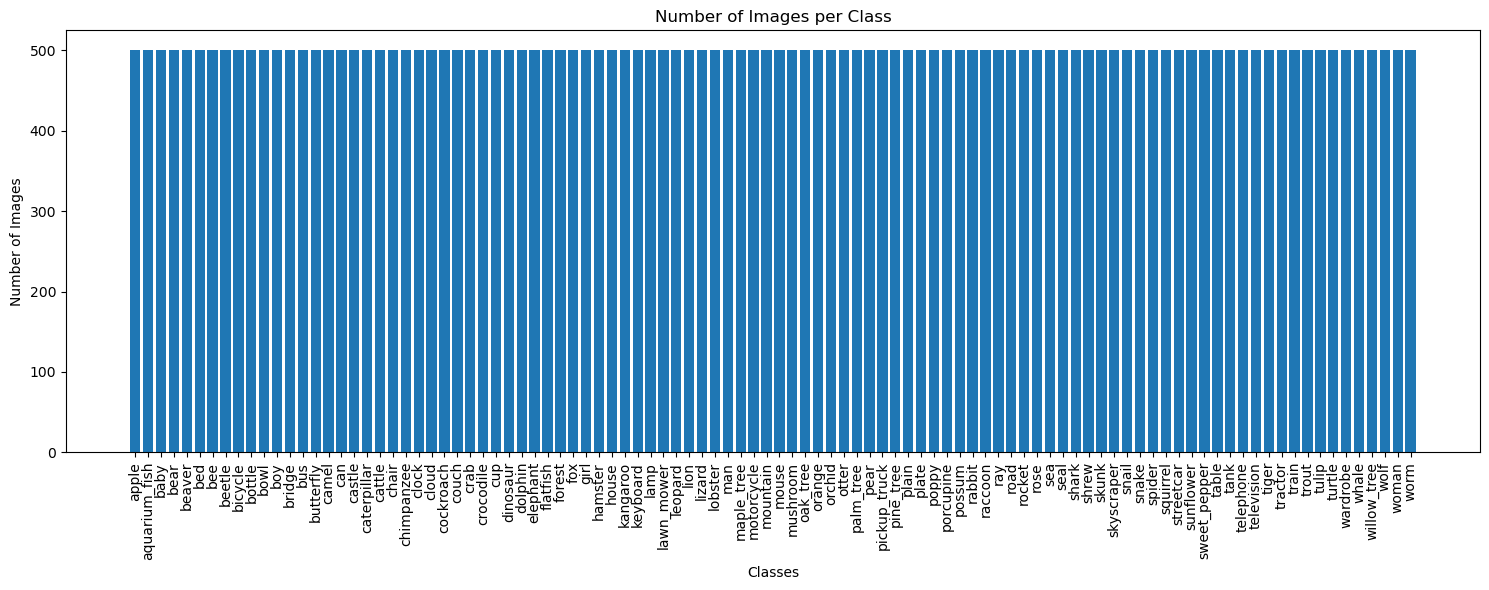

In [19]:
from collections import defaultdict
# Create a dictionary to count images for each class
class_counts = defaultdict(int)

# Count images for each class
for _, label in training_data:
    class_counts[label] += 1

# Get class names
class_names = [training_data.classes[i] for i in range(len(training_data.classes))]

# Create a count plot using matplotlib
plt.figure(figsize=(15, 6))
plt.bar(class_names, [class_counts[i] for i in range(len(class_counts))])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [20]:
val_ratio = 0.2

val_size = int(len(training_data)*0.2)

train_set,val_set = torch.utils.data.random_split(training_data,[len(training_data)-val_size,val_size])
len(train_set),len(val_set)

(40000, 10000)

Dataloader

In [22]:
# if balance just do normal
train_loader = DataLoader(train_set,batch_size = 64,shuffle=True)
val_loader = DataLoader(val_set,batch_size = 64,shuffle=True)
test_loader = DataLoader(testing_data,batch_size = len(testing_data),shuffle=False) # no need to shuffle and batch cuda will not out of memory because no grad cal

In [ ]:
# for not balancedataset

# import torch
# from torch.utils.data import DataLoader, WeightedRandomSampler

# np_targets = np.array(train_set.targets)

# class_weights = [1/len(np_targets[np_targets == i]) for i in range(len(train_set.classes))]  
# sampler = WeightedRandomSampler(class_weights, len(train_set),replacement=True)

# train_loader = DataLoader(train_set, batch_size=64, sampler=sampler) # no need to shuffle sampler is shuffle for you

# val_loader = DataLoader(val_set,batch_size = 64,shuffle=True)
# test_loader = DataLoader(testing_data,batch_size = 6998,shuffle=False)

visulize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
torch.Size([])
torch.Size([3, 32, 32])
torch.Size([])
torch.Size([3, 32, 32])
torch.Size([])
torch.Size([3, 32, 32])
torch.Size([])
torch.Size([3, 32, 32])
torch.Size([])
torch.Size([3, 32, 32])
torch.Size([])


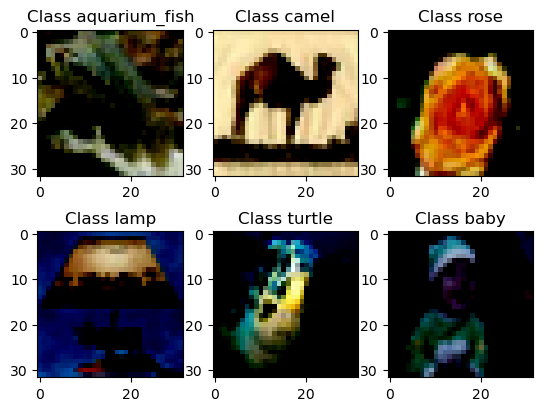

In [24]:

for image, label in train_loader:

    c = 0
    for im,l in zip(image,label):
        print(im.shape) # (bs,ch,h,w)
        print(l.shape) 
        norm = im # np.transpose(image,(0,1,3,2))
        plt.subplot(2, 3, c+1)
        plt.imshow(np.transpose(norm, (1,2,0)))
        plt.title(f"Class {training_data.classes[l.item()]}")

        c+=1

        if c==6:
            break
    break

# Architecture

In [14]:
import torchvision.models as models
from torchinfo import summary

## Inception

https://www.kaggle.com/code/mohamedmustafa/10-implement-inceptionnet-from-scratch-pytorch

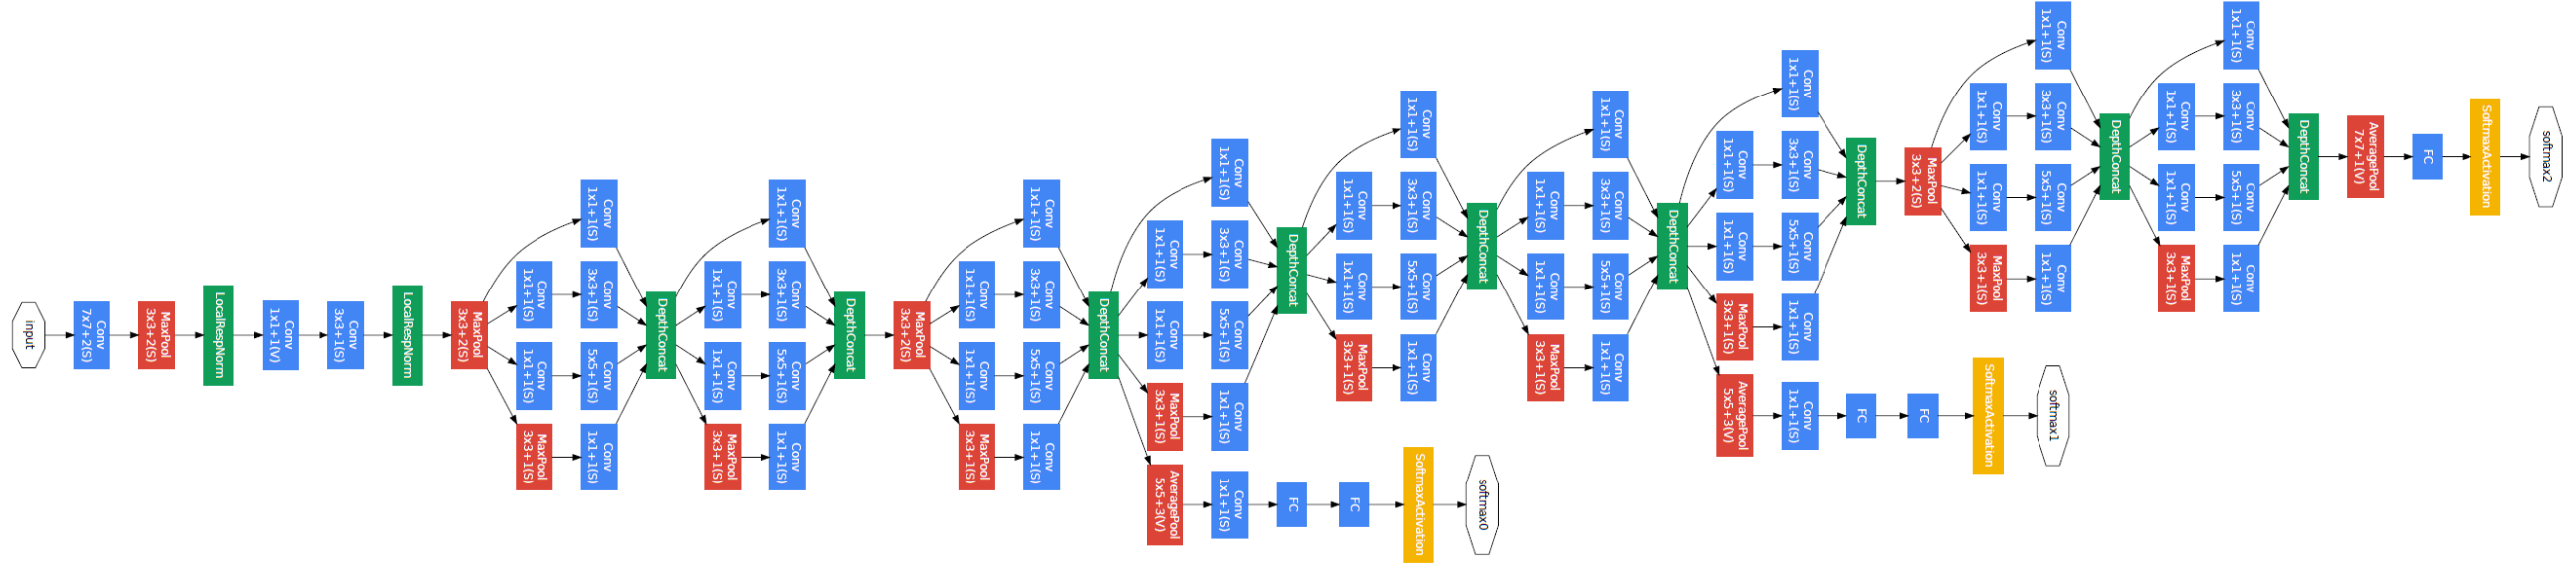

auxiliary use for help with gradient vanishing in paper weight of aux is 0.3

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, In_Channels, Out_Channels, Kernel_Size, Stride, Padding):
        super(ConvBlock, self).__init__()
        self.Conv = nn.Conv2d(in_channels=In_Channels, out_channels=Out_Channels, kernel_size=Kernel_Size, stride=Stride, padding=Padding)
        self.Batch_Norm = nn.BatchNorm2d(num_features=Out_Channels)
        self.Activ_Func = nn.ReLU()
    
    """
    Now we'll build the forward function which defines the path to input tensor
    meaning that we tell the tensor the sequence of layers you're going through 
    Takecare the name of forward function is sensitive so you have to name forward not any thing else
    """
    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Batch_Norm(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)
        
        return Tensor_Path

In [16]:
x = torch.randn(64,1,28,28)
model = ConvBlock(1,3,3,1,1)
print(model(x).shape)
del model

torch.Size([64, 3, 28, 28])


In [17]:


class InceptionBlock(nn.Module):
    def __init__(self,In_Channels, Num_Of_Filters_1x1, Num_Of_Filters_3x3, Num_Of_Filters_5x5, Num_Of_Filters_3x3_Reduce,Num_Of_Filters_5x5_Reduce, Pooling):
        super(InceptionBlock, self).__init__()
        # The In_Channels are the depth of tensor coming from previous layer
        # First block contains only filters with kernel size 1x1
        self.Block_1 = nn.Sequential(ConvBlock(In_Channels=In_Channels, Out_Channels=Num_Of_Filters_1x1, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)))
        
        # Second Block contains filters with kernel size 1x1 followed by 3x3
        self.Block_2 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels= Num_Of_Filters_3x3_Reduce, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)),
            ConvBlock(In_Channels=Num_Of_Filters_3x3_Reduce, Out_Channels= Num_Of_Filters_3x3, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
        )
        
        # Third Block same as second block unless we'll replace the 3x3 filter with 5x5 
        self.Block_3 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels= Num_Of_Filters_5x5_Reduce, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)),
            ConvBlock(In_Channels=Num_Of_Filters_5x5_Reduce, Out_Channels= Num_Of_Filters_5x5, Kernel_Size=(5,5), Stride=(1,1), Padding=(2,2))
        )
        
        # Fourth Block contains maxpooling layer followed by 1x1 filter
        self.Block_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            ConvBlock(In_Channels=In_Channels, Out_Channels=Pooling, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0))
        )
    def forward(self, Tensor_Path):
        First_Block_Out = self.Block_1(Tensor_Path)
        Second_Block_Out = self.Block_2(Tensor_Path)
        Third_Block_Out = self.Block_3(Tensor_Path)
        Fourth_Block_Out = self.Block_4(Tensor_Path)
        
        Concatenated_Outputs = torch.cat([First_Block_Out,Second_Block_Out, Third_Block_Out, Fourth_Block_Out], dim=1) #dim=1 because we want to concatenate in the depth dimension
        return Concatenated_Outputs

In [18]:
Random_Tensor_2 = torch.randn(10, 3, 224, 224) # 10 is number of samples, (3,224,224) is the each sample shape
Test_InceptionBlock = InceptionBlock(In_Channels=3, Num_Of_Filters_1x1=8, Num_Of_Filters_3x3=4, Num_Of_Filters_5x5=4, Num_Of_Filters_3x3_Reduce=16,
                                Num_Of_Filters_5x5_Reduce=32, Pooling=4)
print(Test_InceptionBlock(Random_Tensor_2).shape)

torch.Size([10, 20, 224, 224])


In [19]:
class Auxiliary_Classifier(nn.Module):
    def __init__(self, In_Channels, Num_Classes):
        super(Auxiliary_Classifier, self).__init__()
        self.Adaptive_AvgPool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
        self.Conv = nn.Conv2d(in_channels= In_Channels, out_channels=128, kernel_size=(1,1), stride=(1,1), padding=(0,0))
        self.Activ_Func = nn.ReLU()
        # in_features=2048 because we should flatten the input tensor which has shape of (batch, 4,4,128) so after flaten the tensor will be (batch, 4*4*128)
        # out_features=1024 this number from paper
        self.FC_1 = nn.Linear(in_features=2048, out_features=1024) 
        self.DropOut = nn.Dropout(p=0.7) 
        self.FC_2 = nn.Linear(in_features=1024, out_features= Num_Classes)
    
    def forward(self, Tensor_Path):
        Tensor_Path = self.Adaptive_AvgPool(Tensor_Path)
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.FC_1(Tensor_Path)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC_2(Tensor_Path)
        
        return Tensor_Path

In [20]:
Random_Tensor_3 = torch.randn(28, 512, 14, 14)
Test_Auxiliary = Auxiliary_Classifier(In_Channels=512, Num_Classes=1000)
print(Test_Auxiliary(Random_Tensor_3).shape)

torch.Size([28, 1000])


In [21]:
class InceptionNet_V1(nn.Module):
    def __init__(self, Out_Classes):
        super(InceptionNet_V1, self).__init__()
        self.Conv_1 = ConvBlock(In_Channels=3, Out_Channels=64, Kernel_Size=(7,7), Stride=(2,2), Padding=(3,3))
        self.MaxPool_1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Conv_2 = ConvBlock(In_Channels=64, Out_Channels=64, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0))
        self.Conv_3 = ConvBlock(In_Channels=64, Out_Channels=192, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_3a = InceptionBlock(In_Channels=192, Num_Of_Filters_1x1=64, Num_Of_Filters_3x3=128
                                          , Num_Of_Filters_5x5=32, Num_Of_Filters_3x3_Reduce=96, 
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=32)
        
        self.Inception_3b = InceptionBlock(In_Channels=256, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=192
                                          , Num_Of_Filters_5x5=96, Num_Of_Filters_3x3_Reduce=128, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64)
        
        self.MaxPool_3 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_4a = InceptionBlock(In_Channels=480, Num_Of_Filters_1x1=192, Num_Of_Filters_3x3=208
                                          , Num_Of_Filters_5x5=48, Num_Of_Filters_3x3_Reduce=96, 
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=64)
        
        self.Inception_4b = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=160, Num_Of_Filters_3x3=224
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=112, 
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)
        
        
        self.Inception_4c = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=256
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=128, 
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)
        
       
        self.Inception_4d = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=112, Num_Of_Filters_3x3=288
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=144, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64) 
        
        self.Inception_4e = InceptionBlock(In_Channels=528, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128) 
        
        self.MaxPool_4 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_5a = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128) 
        
        self.Inception_5b = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=384, Num_Of_Filters_3x3=384
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=192, 
                                           Num_Of_Filters_5x5_Reduce=48, Pooling=128) 
        
        self.AvgPool_1 = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.DropOut = nn.Dropout(p=0.4)
        self.FC = nn.Linear(in_features=1024, out_features=Out_Classes)
        
        self.Auxiliary_4a = Auxiliary_Classifier(In_Channels=512, Num_Classes=Out_Classes)
        self.Auxiliary_4d = Auxiliary_Classifier(In_Channels=528, Num_Classes=Out_Classes)
        
    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv_1(Tensor_Path)
        Tensor_Path = self.MaxPool_1(Tensor_Path)
        Tensor_Path = self.Conv_2(Tensor_Path)
        Tensor_Path = self.Conv_3(Tensor_Path)
        Tensor_Path = self.MaxPool_2(Tensor_Path)
        Tensor_Path = self.Inception_3a(Tensor_Path)
        Tensor_Path = self.Inception_3b(Tensor_Path)
        Tensor_Path = self.MaxPool_3(Tensor_Path)
        Tensor_Path = self.Inception_4a(Tensor_Path)
        Auxiliary_1 = self.Auxiliary_4a(Tensor_Path)
        Tensor_Path = self.Inception_4b(Tensor_Path)
        Tensor_Path = self.Inception_4c(Tensor_Path)
        Tensor_Path = self.Inception_4d(Tensor_Path)
        Auxiliary_2 = self.Auxiliary_4d(Tensor_Path)
        Tensor_Path = self.Inception_4e(Tensor_Path)
        Tensor_Path = self.MaxPool_4(Tensor_Path)
        Tensor_Path = self.Inception_5a(Tensor_Path)
        Tensor_Path = self.Inception_5b(Tensor_Path)
        Tensor_Path = self.AvgPool_1(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC(Tensor_Path)
        
        return Tensor_Path, Auxiliary_1, Auxiliary_2

In [22]:
Random_Tensor_4 = torch.randn(51, 3, 224, 224)
Network_Outputs = InceptionNet_V1(Out_Classes=10)
summary(Network_Outputs, Random_Tensor_4.shape)

Layer (type:depth-idx)                   Output Shape              Param #
InceptionNet_V1                          [51, 10]                  --
├─ConvBlock: 1-1                         [51, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [51, 64, 112, 112]        9,472
│    └─BatchNorm2d: 2-2                  [51, 64, 112, 112]        128
│    └─ReLU: 2-3                         [51, 64, 112, 112]        --
├─MaxPool2d: 1-2                         [51, 64, 56, 56]          --
├─ConvBlock: 1-3                         [51, 64, 56, 56]          --
│    └─Conv2d: 2-4                       [51, 64, 56, 56]          4,160
│    └─BatchNorm2d: 2-5                  [51, 64, 56, 56]          128
│    └─ReLU: 2-6                         [51, 64, 56, 56]          --
├─ConvBlock: 1-4                         [51, 192, 56, 56]         --
│    └─Conv2d: 2-7                       [51, 192, 56, 56]         110,784
│    └─BatchNorm2d: 2-8                  [51, 192, 56, 56]         384
│

## Resnet

## VIT

## Custom

# Train

In [3]:
from tqdm import tqdm 
import time

In [ ]:
# define model
param = {}
model = 

In [ ]:
criterion = nn.CrossEntropyLoss()
optim     = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.to(device)

In [ ]:
import os
from pathlib import Path

model_name = ""

assert len(model_name) >0

file_path = f"models/{model_name}"

if not os.path.exists(file_path):
    os.makedirs(file_path,exist_ok=True)

save_path = Path(file_path,f"{model_name}_last.pth")
check_path = Path(file_path,f"{model_name}_best.pth")




In [ ]:
import pickle
# for custom model
data_path = Path(file_path,"data.json")

data = {"param":param,
        "cls":training_data.classes}

with open(data_path,"wb") as file:
    pickle.dump(data,file)


In [ ]:
num_epochs = 5
show_epoch = 1
best_val = np.inf

for i in tqdm(range(num_epochs)):

    train_loss = 0.0
    train_correct = 0
    train_samples = 0

    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_hat = model(images)
        loss = criterion(y_hat, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item()
        train_correct += (torch.max(y_hat, 1)[1] == labels).sum().item()
        train_samples += len(images)

    for images,labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_hat = model(images)
        loss = criterion(y_hat,labels)

        val_loss += loss.item()
        val_correct += (torch.max(y_hat, 1)[1] == labels).sum().item()
        val_samples += len(images)

    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = (train_correct / train_samples) * 100

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = (val_correct / val_samples) * 100

    if epoch_val_loss < best_val:
        best_val = epoch_val_loss
        torch.save(model.state_dict(),check_path)

    if i%show_epoch == show_epoch-1:

        print(f"Epoch: {i+1} | Train acc: {epoch_train_acc:3.2f} | Train Loss: {epoch_train_loss:3.4f} | val acc: {epoch_val_acc:3.2f} | val Loss: {epoch_val_loss:3.4f}")

print(f"Best Val Loss: {best_val:3.4f}")
torch.save(model.state_dict(),save_path)

# Test